# Forecasting future e-commerce sales

In the dynamic landscape of e-commerce, accurately predicting units sold is crucial for ensuring optimal inventory management and maximizing revenue. Moreover, understanding the impact of marketing expenditure, especially during campaign periods, is essential for crafting effective strategies to drive sales and customer engagement. 

In other words, imagine you're trying to predict the future sales of an online store. You know that past sales can give you hints about what's going to happen, but the sales data might be influenced by many things at once, like marketing campaigns, seasonal trends, or even random events.

By comparing forecasting models like VARIMA from DARTS library, Prophet by Meta, and ForecasterAutoreg from SKForecast, e-commerce businesses can unlock powerful insights into consumer behavior and market trends. These models offer sophisticated tools to analyze historical sales data alongside marketing initiatives, enabling businesses to forecast units sold with greater precision and anticipate the effects of marketing campaigns or web traffic trends on future sales. Through this comparative analysis, e-commerce stakeholders can enhance their predictive capabilities, optimize resource allocation, and make data-driven decisions that propel their businesses to success in the competitive online marketplace.

## Pre-processing our data

The data provided is synthetic and entirely fictitious. Consequently, it may not accurately reflect situations encountered in real e-commerce data. To simulate realistic scenarios, deliberate gaps have been introduced to mimic instances when servers were off or bugs occurred. While this notebook does not delve deeply into correcting imperfect datasets, I thought it may be useful to include these "effects" to make the fake data closer to reality :) 

In [1]:
# Requirements needed
# !pip install -r requirements.txt

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Error metrics to measure our models performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Loading the data
data = pd.read_csv('time_series_dataframe.csv')

print("Are there any missing values?")
data.isna().any()

Are there any missing values?


date                  False
users                  True
sessions               True
marketing_cost        False
clicks                False
impressions           False
click_through_rate    False
avg_time_on_page       True
bouce_rate             True
units_sold             True
is_campaign_period    False
day_of_week           False
month_number          False
dtype: bool

### Fill the missing values
To handle a specific column and interpolate missing values when seven consecutive days are missing, you can use the interpolate()

method='linear': Assumes a linear relationship between consecutive points, regardless of the time intervals between them. It works well when the time intervals between data points are relatively constant.

method='time': Takes into account the time intervals between data points when interpolating. It considers the time component, making it more suitable for time series data where the intervals between data points are irregular or unevenly spaced.

In [4]:
# Value imputation using linear interpolation
data = data.interpolate(method='linear')

print("Are there any missing values?")
data.isna().any()

Are there any missing values?


date                  False
users                 False
sessions              False
marketing_cost        False
clicks                False
impressions           False
click_through_rate    False
avg_time_on_page      False
bouce_rate            False
units_sold            False
is_campaign_period    False
day_of_week           False
month_number          False
dtype: bool

In [5]:
# Convert columns to the right types
data['date'] = pd.to_datetime(data['date'])
data['users'] = pd.to_numeric(data['users'], errors='coerce')
data['sessions'] = pd.to_numeric(data['sessions'], errors='coerce')
data['marketing_cost'] = pd.to_numeric(data['marketing_cost'], errors='coerce')
data['clicks'] = pd.to_numeric(data['clicks'], errors='coerce')
data['impressions'] = pd.to_numeric(data['impressions'], errors='coerce')
data['click_through_rate'] = pd.to_numeric(data['click_through_rate'], errors='coerce')
data['avg_time_on_page'] = pd.to_numeric(data['avg_time_on_page'], errors='coerce')
data['bouce_rate'] = pd.to_numeric(data['bouce_rate'], errors='coerce')
data['units_sold'] = pd.to_numeric(data['units_sold'], errors='coerce')
data['is_campaign_period'] = pd.to_numeric(data['is_campaign_period'], errors='coerce')
data['day_of_week'] = pd.to_numeric(data['day_of_week'], errors='coerce')
data['month_number'] = pd.to_numeric(data['month_number'], errors='coerce')

### Define the parameters for the models
We need to define what are the amount of periods (days in this case) we want to predict and the last date of our training set. In other words, we define the date where the predictions will start.


In [6]:
periods_to_predict = 30
# end_training_date = '2023-02-19' # In case you want to test a time frame without marketing campaign periods
end_training_date = '2023-03-19'

### Split our data into train and test
Based on the defined parameters, the data gets split for training and forecasting

In [7]:
# Filter data before the determined end training date
data_train = data[data['date'] < end_training_date]

# Create date with end_training_date + periods_to_predict
last_forecasting_date = data_train.date.max() + pd.Timedelta(days=periods_to_predict + 1)

# Create dataframe with all data (past and future). This is important because we need to feed the 
#   models with future regressors
all_data = data[data['date'] < last_forecasting_date]

# Create dataframe with all available data until end training date
data_test = data[(data['date'] < last_forecasting_date) & (data['date'] >= end_training_date)]

# 




## Darts: Forecasting with VARIMA

Darts is a Python library for user-friendly forecasting and anomaly detection on time series. It contains a variety of models, from classics such as ARIMA to deep neural networks. 

We will use VARIMA, which stands for Vector Autoregressive Moving Average, is a mathematical tool that helps in making predictions by taking into account the relationships between multiple variables over time. In simpler terms, it's like looking at how different factors interact and influence each other in the past to forecast what might happen in the future.

### How does it work?
It is composed by two methods:
- Vector Autoregression (VAR): This part looks at how each variable, like sales, marketing spending, or website traffic, depends on its own past values and the past values of other variables. For example, it might find that sales today are influenced not only by sales yesterday but also by the amount of money spent on advertising two days ago.
- Moving Average (MA): This part smoothens out the data by taking averages over consecutive time periods, which helps in spotting trends and patterns.

Combining these two methods, VARIMA can capture complex relationships and patterns in the data, allowing for more accurate forecasts. In the context of e-commerce sales forecasting, this is crucial because online sales can be affected by various factors like promotions, seasonal trends, or even external events like holidays or economic changes

In [8]:
# Import libraries
from darts.models import VARIMA
from darts import TimeSeries

/Users/alvaro/anaconda3/lib/python3.11/site-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.58754e-19): result may not be accurate.
  x = solve(lhs, q.flatten())
/Users/alvaro/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mean_absolute_error: 129.81863084349985
mean_squared_error: 182.3697502969542


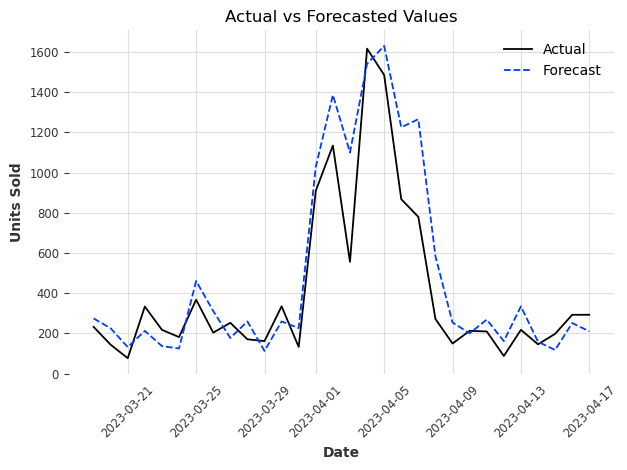

In [9]:
# Selecting relevant columns for analysis
data_train_selected = data_train[['date', 'users', 'units_sold', 'sessions', 
                                  'clicks', 'impressions', 'click_through_rate', 'avg_time_on_page']]

# Converting dataframe to a time series
series = TimeSeries.from_dataframe(data_train_selected, 'date', ['units_sold', 'users', 'sessions', 
                                                                 'avg_time_on_page', 'click_through_rate'])

# Since we want to be more accurate on our forecasts and explain what impacts our predictions, 
#   we include regressors or exogenous variables in the models
future_cov = TimeSeries.from_dataframe(all_data, 'date', ['marketing_cost', 'is_campaign_period'])
pred_cov = TimeSeries.from_dataframe(data_test, 'date', ['marketing_cost', 'is_campaign_period'])

# Initializing the VARIMA model with trend
model = VARIMA(trend = 'ct')

# Fitting the VARIMA model
model.fit(series, future_covariates = future_cov)

# Generating predictions for the next 15 time points
pred = model.predict(periods_to_predict, future_covariates = pred_cov)
pred.values()

# Extracting forecasted values for 'units_sold'
forecast_values = pred.univariate_component('units_sold').values()

# Extracting actual values for 'units_sold'
actual_data = data_test.tail(periods_to_predict)['units_sold'].values

# Calculating metrics to evaluate model performance
mae_darts = mean_absolute_error(actual_data, forecast_values)
rmse_darts = np.sqrt(mean_squared_error(actual_data, forecast_values))

# Print results
print("mean_absolute_error:", mae_darts)
print("mean_squared_error:", rmse_darts)

# Extracting dates for x-axis
dates = pd.to_datetime(data_test.tail(periods_to_predict)['date'])

# Plotting actual values
plt.plot(dates, actual_data, label='Actual')

# Plotting forecasted values
plt.plot(dates, forecast_values, label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Values')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


# 




## Machine Learning approach: SKForecast

Machine Learning methods like ForecasterAutoreg offer a flexible and data-driven approach to e-commerce sales forecasting, leveraging algorithms to learn patterns from historical data and incorporate various factors that influence sales. 

Some of the main benefits and why I like this library:
- ForecasterAutoreg incorporates an autoregressive component, which means it considers how past values of the target variable (i.e. units sold) influence its future values. So it learns that sales today are related to sales in the previous days or weeks (lags). In order to explain the predictions, you can obtain the feature importance and/or calculate the SHAP values - which is extremely useful to communicate with non-tecnical stakeholders.
- It is very simple to input exogenous variables with SKForecast. These variables like marketing spending, website traffic, or external factors like holidays can provide valuable context and improve the accuracy of forecasts by capturing additional information.

In [10]:
# Import libraries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

In [11]:
def process_data_skforecast(df):
    """
    Process the DataFrame by converting the 'date' column to datetime format,
    setting it as the index, resampling to daily frequency, and sorting by date.
    
    Args:
    df (DataFrame): Input DataFrame with a 'date' column
    
    Returns:
    DataFrame: Processed DataFrame with datetime index
    """
    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    
    # Set 'date' column as index
    df = df.set_index('date')
    
    # Resample to daily frequency
    df = df.asfreq('D')
    
    # Sort DataFrame by date
    df = df.sort_index()
    
    return df

# Apply function over datasets for skforecast
data_train_skforecast = process_data_skforecast(data_train)
data_test_skforecast = process_data_skforecast(data_test)

/var/folders/09/l73dc03x6cs7vdpqdt9wls3r0000gn/T/ipykernel_8380/2461230209.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
/var/folders/09/l73dc03x6cs7vdpqdt9wls3r0000gn/T/ipykernel_8380/2461230209.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


### Autoregressive model

A autoregressive model (ForecasterAutoreg) is trained using a linear regressor with Ridge regularization, and a time window of 2 weeks (14 lags). The latter means that, for each prediction, the traffic the website had in the previous 14 days is used as predictors.

Ridge models require predictors to be standardized. A StandardScaler is added to the forecaster using the argument transformer_y.

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 14
             )

forecaster.fit(
    y    = data_train_skforecast['units_sold'],
    exog = data_train_skforecast[['marketing_cost', 'is_campaign_period']]
)

forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: None 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['marketing_cost', 'is_campaign_period'] 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2023-03-18 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 202

In [13]:
# Predict
# ==============================================================================
steps = periods_to_predict
predictions = forecaster.predict(
                  steps = steps,
                  exog = data_test_skforecast[['marketing_cost', 'is_campaign_period']]
              )

mean_absolute_error: 78.5117962962963
mean_squared_error: 92.57306455553744


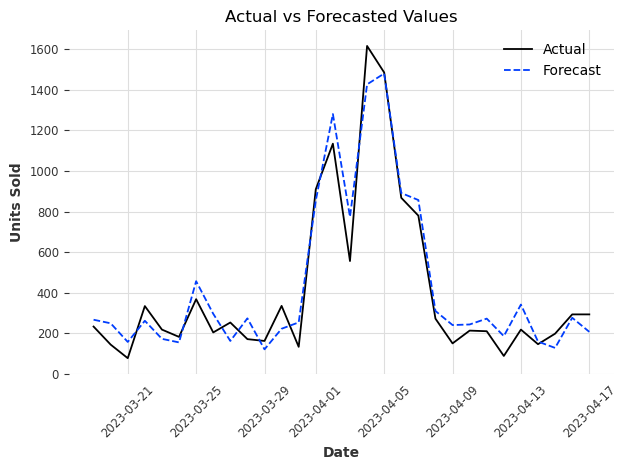

In [14]:
# Calculating metrics to evaluate model performance
mae_skforecast = mean_absolute_error(actual_data, predictions)
rmse_skforecast = mean_squared_error(actual_data, predictions, squared=False)

# Print the results
print("mean_absolute_error:", mae_skforecast)
print("mean_squared_error:", rmse_skforecast)

# Plotting actual values
plt.plot(data_test_skforecast.index, data_test['units_sold'], label='Actual')

# Plotting forecasted values
plt.plot(data_test_skforecast.index, predictions, label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Values')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

In [15]:
# Show what are the most important features that explain the predictions
#  Note: lag_1 refers to the values from the previous day; lag_2 to the values from 2 days ago; and so on
forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

,feature,importance
14,marketing_cost,0.680599
15,is_campaign_period,0.200259
0,lag_1,0.022298
12,lag_13,0.019752
1,lag_2,0.015170
10,lag_11,0.009241
2,lag_3,0.007572
3,lag_4,0.006038
6,lag_7,0.005521
13,lag_14,0.005434


# 




## Forecasting with Prophet from Meta

Prophet offers a robust and flexible framework for time-series forecasting, leveraging Bayesian methods to capture trends, seasonality, and holiday effects while providing measures of uncertainty. Its intuitive interface and automatic model fitting make it accessible to users with varying levels of expertise, making it a popular choice for forecasting applications across different industries.

### How does it work? 

- Trend Modeling: Prophet captures the overall trend in the time-series data using a piecewise linear or logistic function. Instead of assuming a single global trend, Prophet allows for changes in trend direction at specific points in time, known as changepoints. These changepoints are automatically detected based on the data or can be manually specified by the user.
- Seasonality Modeling: Prophet accounts for periodic fluctuations or seasonal patterns in the data. It automatically detects weekly, monthly, and yearly seasonalities using Fourier series expansions. This allows Prophet to capture the repetitive patterns that occur at fixed intervals within the time series.
- Holiday Effects: Prophet allows users to specify custom holidays and events that may impact the time series. These holidays can have both positive and negative effects on the data, and Prophet includes them as additional components in the forecasting model.
- Uncertainty Estimation: Prophet provides uncertainty intervals around the forecasted values, allowing users to assess the reliability of the forecasts. These uncertainty intervals account for both the inherent variability in the data and the uncertainty associated with the model parameters.
- Automatic Model Fitting: Prophet automatically fits the forecasting model to the data using a Bayesian framework. This involves estimating the parameters of the trend, seasonality, and holiday components while accounting for uncertainty. Prophet uses Markov Chain Monte Carlo (MCMC) methods or optimization algorithms to sample from the posterior distribution of the parameters and obtain the most likely values.
- Forecasting: Once the model is fitted to the data, Prophet generates forecasts for future time periods based on the learned patterns and trends. These forecasts include point estimates as well as uncertainty intervals, providing users with a range of possible outcomes.

prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/09/l73dc03x6cs7vdpqdt9wls3r0000gn/T/tmpzlb7fo_i/mxnn63p_.json
cmdstanpy  DEBUG input tempfile: /var/folders/09/l73dc03x6cs7vdpqdt9wls3r0000gn/T/tmpzlb7fo_i/b1nxyr7w.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/alvaro/anaconda3/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69700', 'data', 'file=/var/folders/09/l73dc03x6cs7vdpqdt9wls3r0000gn/T/tmpzlb7fo_i/mxnn63p_.json', 'init=/var/folders/09/l73dc03x6cs7vdpqdt9wls3r0000gn/T/tmpzlb7fo_i/b1nxyr7w.json', 'output', 'file=/var/folders/09/l73dc03x6cs7vdpqdt9wls3r0000gn/T/tmpzlb7fo_i/prophet_modelbp_z6ch5/prophet_model-20240425195333.csv', 'method=optimize', 'algorithm=lbfgs', 'ite

mean_absolute_error: 131.01236230314998
mean_squared_error: 190.4623449772279


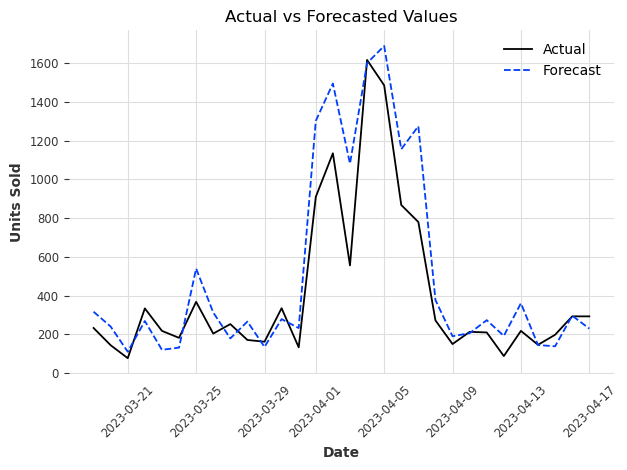

In [16]:
from prophet import Prophet

# Selecting relevant columns for analysis
data_train_selected = data_train[['date', 'users', 'units_sold', 'sessions', 'clicks', 'impressions', 'click_through_rate', 'avg_time_on_page', 'marketing_cost', 'is_campaign_period']]

# Converting dataframe to a time series
data_train_selected.columns = ['ds'] + data_train_selected.columns[1:].tolist()
data_train_selected = data_train_selected.rename(columns={'units_sold': 'y'})
series = data_train_selected

# Initializing the Prophet model
model = Prophet()

# Adding regressors to the model
for regressor in ['marketing_cost', 'is_campaign_period']:
    model.add_regressor(regressor)

# Fitting the Prophet model
model.fit(series)

# Creating future dataframe for prediction
future_df = model.make_future_dataframe(periods=periods_to_predict)

# Adding regressor values to the future dataframe
for regressor in ['marketing_cost', 'is_campaign_period']:
    future_df[regressor] = all_data[regressor].values

# Generating predictions
forecast = model.predict(future_df)

# Extracting forecasted values for 'units_sold'
forecast_values_prophet = forecast[['ds', 'yhat']].tail(periods_to_predict)['yhat'].values

# Extracting actual values
actual_data = data_test.tail(periods_to_predict)['units_sold'].values

# Calculating metrics to evaluate model performance
mae_prophet = mean_absolute_error(actual_data, forecast_values_prophet)
rmse_prophet = np.sqrt(mean_squared_error(actual_data, forecast_values_prophet))

print("mean_absolute_error:", mae_prophet)
print("mean_squared_error:", rmse_prophet)

# Plotting
plt.plot(data_test.tail(periods_to_predict)['date'], actual_data, label='Actual')
plt.plot(data_test.tail(periods_to_predict)['date'], forecast_values_prophet, label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 




## Compare the 3 models

As you could see, sometimes the model may predict too high, and sometimes too low. In order to determine which is the best performing model for our data and the selected time frame, we will use two important measures:
- Mean Absolute Error (MAE): This tells us how far off, on average, our predictions were from the actual sales numbers. Lower MAE means our guesses were closer to the real sales numbers, which is what we want.
- Root Mean Squared Error (RMSE): This is similar to MAE, but it emphasizes bigger mistakes more. It helps us understand how much our predictions varied from the actual sales, considering both small and large mistakes.

By looking at both MAE and RMSE, we can figure out which method does the best job of predicting sales. Ideally, we want a model with both low MAE and RMSE because that means it's making the most accurate predictions overall

In [17]:
# Create dataset with the required error values
model_error_comparison = {
    'MAE': {
        'prophet': mae_prophet,
        'skforecast': mae_skforecast,
        'darts': mae_darts
    },
    'RMSE': {
        'prophet': rmse_prophet,
        'skforecast': rmse_skforecast,
        'darts': rmse_darts
    }
}

# Create a DataFrame object and display it
model_error_comparison = pd.DataFrame(model_error_comparison).sort_values(by='MAE', ascending=True)
model_error_comparison

,MAE,RMSE
skforecast,78.511796,92.573065
darts,129.818631,182.369750
prophet,131.012362,190.462345


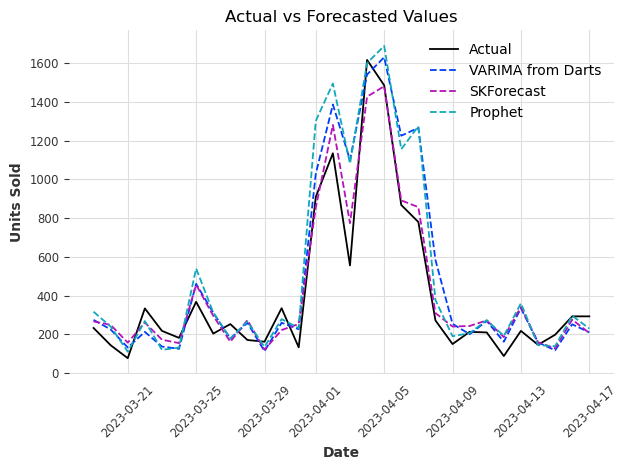

In [19]:
# Extracting dates for x-axis
dates = pd.to_datetime(data_test.tail(periods_to_predict)['date'])

# Plotting actual values
plt.plot(dates, actual_data, label='Actual')

# Plotting forecasted values for each model
plt.plot(dates, forecast_values, label='VARIMA', linestyle='dashed')
plt.plot(dates, predictions, label='SKForecast', linestyle='dashed')
plt.plot(dates, forecast_values_prophet, label='Prophet', linestyle='dashed')

# Show chart with all forecasts
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Forecasted Values')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

With a Mean Absolute Error (MAE) of approximately 78.51 and a Root Mean Squared Error (RMSE) of about 92.57. This means, on average, its predictions were off by around 78.51 units. For our particular case, during this specific range of time that includes marketing campaign periods, SKForecast performs better than the other models used from other libraries. 

However, testing different time frames is important to understand on which situations each model is more appropriate. I tested other time frames without marketing campaign periods and VARIMA from Darts seemed to perform better.

As always in data, the choice between models and libraries is not obvious. Each method has its strengths and weaknesses, so it's essential to consider your specific forecasting needs and the characteristics of your data when selecting the most suitable tool for your application. 

However, this is a brief summary of the selected libraries in case you may find it useful:

| Dimension                    | Prophet                                     | SKForecast                                 | Darts                                      |
|------------------------------|---------------------------------------------|--------------------------------------------|--------------------------------------------|
| **Ease of Use**              | Known for its simplicity and user-friendly interface, making it accessible to users with varying levels of expertise. | Requires some level of familiarity with Python and machine learning concepts, but provides comprehensive documentation and examples to facilitate usage. | Offers a high level of flexibility but may require more technical expertise due to its extensive range of functionalities and customization options. |
| **Flexibility and Customization** | Offers limited flexibility compared to `skforecast` and `darts`, with fewer options for algorithm customization and feature engineering. | Provides a wide range of forecasting algorithms and techniques, allowing for fine-grained control over the forecasting process and model configuration. | Offers extensive customization options, including various forecasting models, feature transformations, and hyperparameter tuning, making it highly adaptable to different use cases and datasets. |
| **Performance and Scalability** | Designed to handle medium-scale time-series datasets efficiently but may encounter performance issues with very large datasets due to its Bayesian modeling approach. | Highly scalable and suitable for large-scale time-series data, with optimized implementations of forecasting algorithms and efficient memory management. | Optimized for performance and scalability, capable of handling large-scale time-series datasets with millions of data points using parallel processing and memory-efficient algorithms. |
| **Integration and Ecosystem** | Seamlessly integrates with the Python ecosystem and popular data analysis libraries such as Pandas, making it easy to incorporate into existing workflows. | Built on top of scikit-learn, a widely used machine learning library in Python, and integrates well with other libraries for data preprocessing, visualization, and model evaluation. | Designed to work with the PyTorch ecosystem, providing access to a rich set of deep learning tools and libraries for time-series analysis and forecasting. |
| **Community and Support**    | Backed by a large community of users and contributors, with extensive documentation, tutorials, and online resources available for support. | Supported by the scikit-learn community and active development, with regular updates and improvements based on user feedback. | Relatively newer compared to Prophet and scikit-learn but gaining popularity rapidly, with a growing community of users and contributors and active development. |
